In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!nvidia-smi

Thu Dec  4 17:00:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jockeroika/human-bone-fractures-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-bone-fractures-image-dataset


In [3]:
import os
import yaml
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from sklearn.utils.class_weight import compute_class_weight

In [5]:
# Load configuration
with open('/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection/data.yaml') as f:
    data_config = yaml.safe_load(f)

In [7]:

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_EPOCHS = 25
LEARNING_RATE = 0.0005
NUM_CLASSES = len(data_config['names'])
CLASS_NAMES = data_config['names']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Enhanced Dataset
class BoneFractureDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.image_dir = os.path.join(root_dir, mode, 'images')
        self.label_dir = os.path.join(root_dir, mode, 'labels')
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)
        
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])
        else:
            label = 0
            
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [11]:
# Enhanced Augmentation
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [12]:
# Create datasets
train_dataset = BoneFractureDataset(
    root_dir='/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection',
    transform=train_transform,
    mode='train'
)

val_dataset = BoneFractureDataset(
    root_dir='/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection',
    transform=val_transform,
    mode='valid'
)

test_dataset = BoneFractureDataset(
    root_dir='/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection',
    transform=val_transform,
    mode='test'
)

In [13]:

# Check class distribution
def check_class_distribution(dataset, name):
    counts = torch.zeros(NUM_CLASSES)
    for _, label in dataset:
        counts[label] += 1
    print(f"\nClass distribution in {name} set:")
    for i, count in enumerate(counts):
        print(f"Class {i} ({CLASS_NAMES[i]}): {int(count)} samples")

check_class_distribution(train_dataset, 'train')
check_class_distribution(val_dataset, 'validation')
check_class_distribution(test_dataset, 'test')


Class distribution in train set:
Class 0 (Comminuted): 153 samples
Class 1 (Greenstick): 75 samples
Class 2 (Healthy): 54 samples
Class 3 (Linear): 21 samples
Class 4 (Oblique Displaced): 297 samples
Class 5 (Oblique): 48 samples
Class 6 (Segmental): 12 samples
Class 7 (Spiral): 66 samples
Class 8 (Transverse Displaced): 531 samples
Class 9 (Transverse): 90 samples

Class distribution in validation set:
Class 0 (Comminuted): 14 samples
Class 1 (Greenstick): 7 samples
Class 2 (Healthy): 7 samples
Class 3 (Linear): 1 samples
Class 4 (Oblique Displaced): 28 samples
Class 5 (Oblique): 7 samples
Class 6 (Segmental): 3 samples
Class 7 (Spiral): 5 samples
Class 8 (Transverse Displaced): 47 samples
Class 9 (Transverse): 9 samples

Class distribution in test set:
Class 0 (Comminuted): 9 samples
Class 1 (Greenstick): 1 samples
Class 2 (Healthy): 3 samples
Class 3 (Linear): 0 samples
Class 4 (Oblique Displaced): 16 samples
Class 5 (Oblique): 2 samples
Class 6 (Segmental): 0 samples
Class 7 (Spir

In [15]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [16]:
# Enhanced Model
class FractureClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = models.efficientnet_b4(weights='DEFAULT')
        num_ftrs = self.base_model.classifier[1].in_features
        
        self.attention_gate = torch.nn.Sequential(
            torch.nn.Conv2d(num_ftrs, num_ftrs//8, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(num_ftrs//8, 1, kernel_size=1),
            torch.nn.Sigmoid()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(num_ftrs, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)
        attention = self.attention_gate(features)
        attended_features = features * attention
        pooled = torch.nn.functional.adaptive_avg_pool2d(attended_features, (1, 1))
        flattened = torch.flatten(pooled, 1)
        return self.classifier(flattened), attention

model = FractureClassifier(NUM_CLASSES).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 145MB/s] 


In [17]:
# Enhanced Class Weighting
def get_enhanced_class_weights(dataset):
    y = [label for _, label in dataset]
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    
    weight_multipliers = {
        'Comminuted': 3.0,
        'Transverse Displaced': 2.0,
        'Healthy': 0.7,
        'Oblique Displaced': 1.5
    }
    
    for cls, mult in weight_multipliers.items():
        if cls in CLASS_NAMES:
            idx = CLASS_NAMES.index(cls)
            class_weights[idx] *= mult
    
    return torch.tensor(class_weights, dtype=torch.float).to(device)

class_weights = get_enhanced_class_weights(train_dataset)

In [18]:
# Hybrid Loss
class HybridLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, ce_weight=0.3):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce_weight = ce_weight
        self.ce_loss = torch.nn.CrossEntropyLoss(weight=alpha)

    def forward(self, inputs, targets):
        ce = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce)
        focal_loss = ((1 - pt) ** self.gamma * ce).mean()
        return self.ce_weight * ce + (1 - self.ce_weight) * focal_loss

criterion = HybridLoss(alpha=class_weights, gamma=2.0, ce_weight=0.4)


In [19]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [20]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_acc is None:
            self.best_acc = val_acc
        elif val_acc < self.best_acc + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_acc = val_acc
            self.counter = 0
        return self.early_stop

early_stopping = EarlyStopping(patience=7)

In [21]:

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            if phase == 'val':
                scheduler.step(epoch_acc)
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), 'best_model.pth')
                    print(f'Model saved with validation accuracy: {best_acc:.4f}')
                
                if early_stopping(epoch_acc):
                    print("Early stopping triggered!")
                    return model, history
    
    print(f'\nBest validation Accuracy: {best_acc:.4f}')
    return model, history

In [22]:
# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, NUM_EPOCHS)



Epoch 1/25
----------
train Loss: 1.6995 Acc: 0.2673
val Loss: 1.1074 Acc: 0.2812
Model saved with validation accuracy: 0.2812

Epoch 2/25
----------
train Loss: 0.8886 Acc: 0.4996
val Loss: 0.5235 Acc: 0.5312
Model saved with validation accuracy: 0.5312

Epoch 3/25
----------
train Loss: 0.4057 Acc: 0.6748
val Loss: 0.3946 Acc: 0.5703
Model saved with validation accuracy: 0.5703

Epoch 4/25
----------
train Loss: 0.2462 Acc: 0.7788
val Loss: 0.2003 Acc: 0.6641
Model saved with validation accuracy: 0.6641

Epoch 5/25
----------
train Loss: 0.1451 Acc: 0.8426
val Loss: 0.1945 Acc: 0.8047
Model saved with validation accuracy: 0.8047

Epoch 6/25
----------
train Loss: 0.1033 Acc: 0.8909
val Loss: 0.1012 Acc: 0.9062
Model saved with validation accuracy: 0.9062

Epoch 7/25
----------
train Loss: 0.0616 Acc: 0.9287
val Loss: 0.0885 Acc: 0.9297
Model saved with validation accuracy: 0.9297

Epoch 8/25
----------
train Loss: 0.0635 Acc: 0.9428
val Loss: 0.0867 Acc: 0.9141

Epoch 9/25
---------

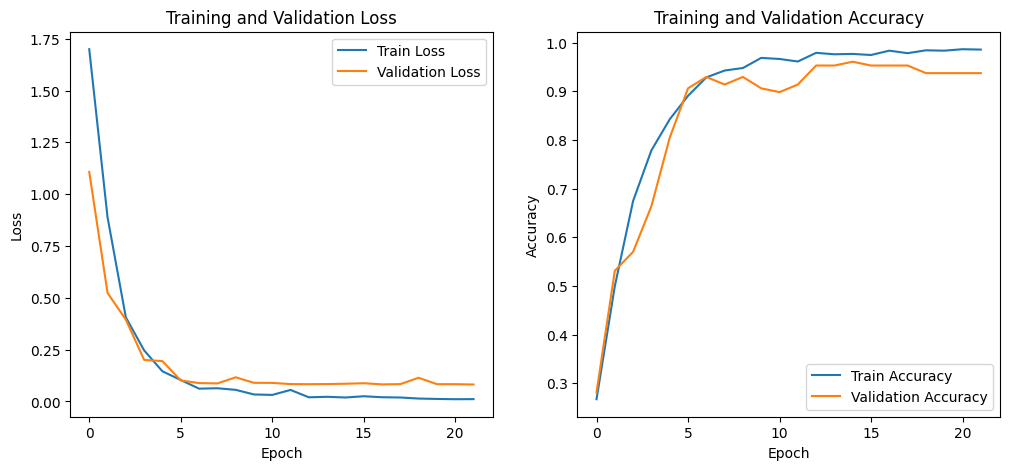

In [23]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)


In [25]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    attention_maps = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, attention = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            attention_maps.extend(attention.cpu().numpy())
    
    present_classes = np.unique(all_labels)
    present_class_names = [CLASS_NAMES[i] for i in present_classes]
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=present_class_names,
                              labels=present_classes,
                              zero_division=0))
    
    cm = confusion_matrix(all_labels, all_preds, labels=present_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=present_class_names,
               yticklabels=present_class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return all_preds, all_labels, all_probs, attention_maps



Evaluating on test set...

Classification Report:
                      precision    recall  f1-score   support

          Comminuted       1.00      1.00      1.00         9
          Greenstick       1.00      1.00      1.00         1
             Healthy       1.00      1.00      1.00         3
   Oblique Displaced       1.00      1.00      1.00        16
             Oblique       1.00      1.00      1.00         2
              Spiral       1.00      1.00      1.00         3
Transverse Displaced       1.00      1.00      1.00        22
          Transverse       1.00      1.00      1.00         8

            accuracy                           1.00        64
           macro avg       1.00      1.00      1.00        64
        weighted avg       1.00      1.00      1.00        64



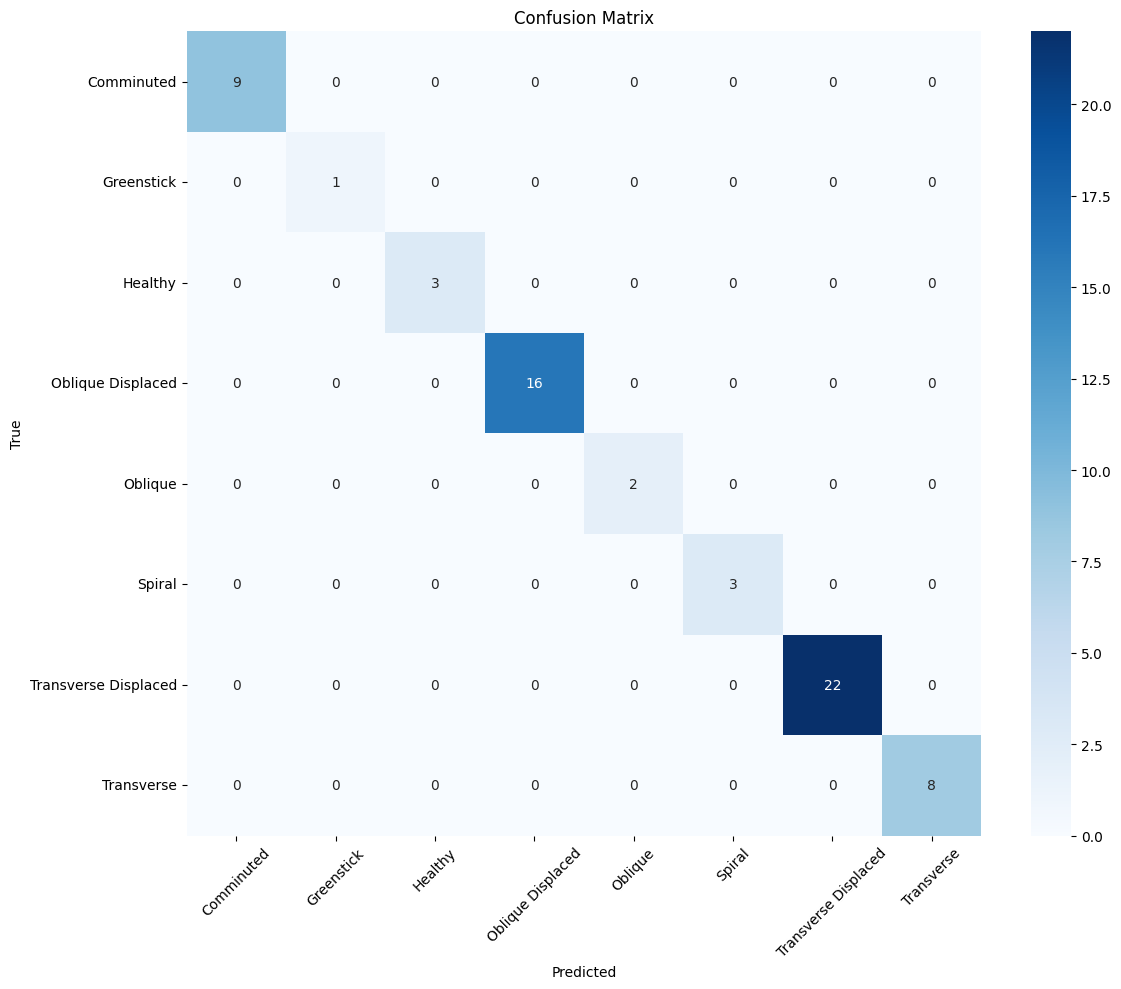

In [26]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
print("\nEvaluating on test set...")
predictions, true_labels, probabilities, attentions = evaluate_model(model, test_loader)


Total errors: 0/64


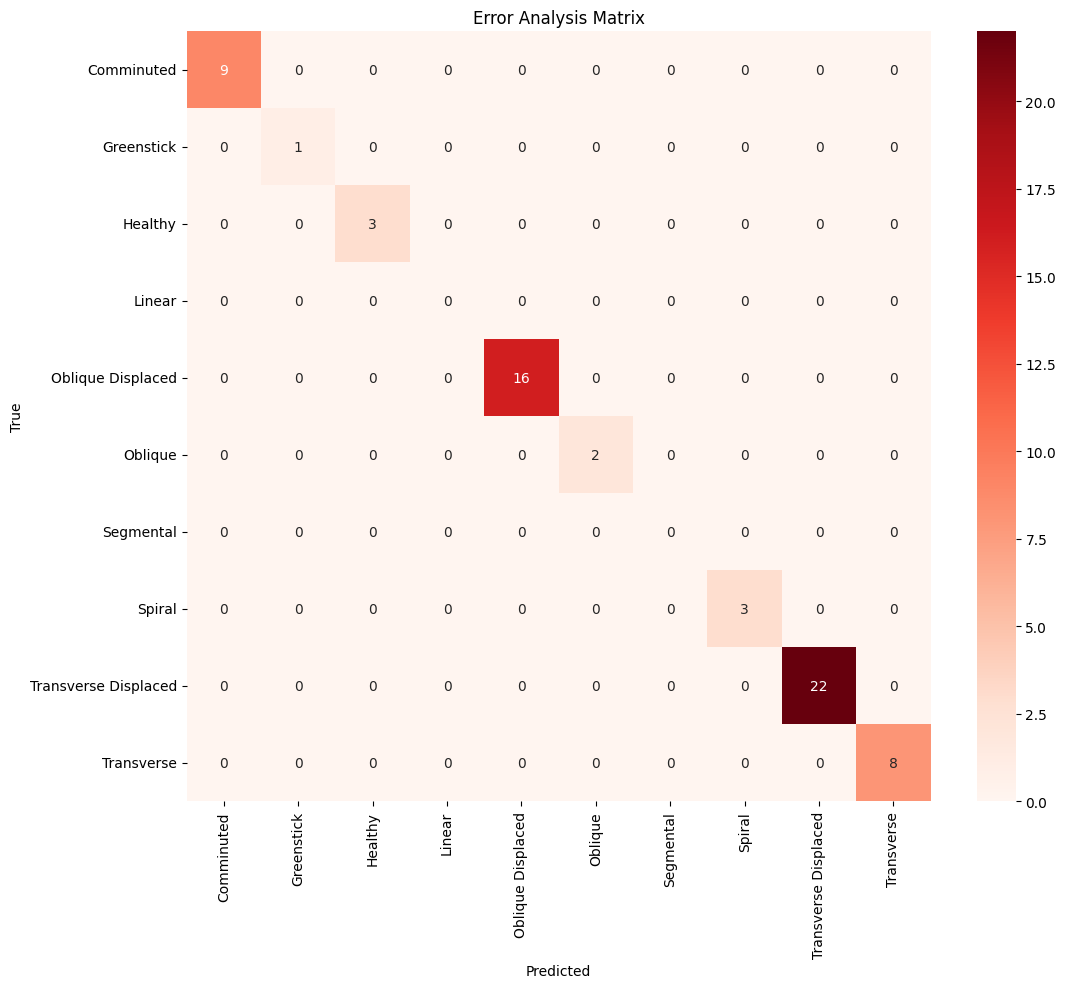


Critical Error Analysis:
Comminuted → Transverse Displaced: 0.0 errors
Transverse Displaced → Healthy: 0.0 errors


In [34]:
# Error analysis
def analyze_errors(true_labels, pred_labels, class_names):
    error_indices = np.where(np.array(true_labels) != np.array(pred_labels))[0]
    print(f"\nTotal errors: {len(error_indices)}/{len(true_labels)}")
    
    error_matrix = np.zeros((len(class_names), len(class_names)))
    for true, pred in zip(true_labels, pred_labels):
        error_matrix[true, pred] += 1
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(error_matrix, annot=True, fmt='g', cmap='Reds',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Error Analysis Matrix')
    plt.show()
    
    # Critical error analysis
    critical_pairs = [('Comminuted', 'Transverse Displaced'),
                     ('Transverse Displaced', 'Healthy')]
    
    print("\nCritical Error Analysis:")
    for true_class, pred_class in critical_pairs:
        if true_class in class_names and pred_class in class_names:
            true_idx = class_names.index(true_class)
            pred_idx = class_names.index(pred_class)
            count = error_matrix[true_idx, pred_idx]
            print(f"{true_class} → {pred_class}: {count} errors")

analyze_errors(true_labels, predictions, CLASS_NAMES)

In [35]:

# Grad-CAM Visualization
def visualize_gradcam(model, test_loader, class_names, num_samples=3):
    model.eval()
    
    # Hook for feature maps
    feature_maps = []
    def forward_hook(module, input, output):
        feature_maps.append(output.detach())
    
    # Using full backward hook
    gradients = []
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())
    
    # Register hooks to the last convolutional layer
    target_layer = model.base_model.features[-1]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)
    
    try:
        # Get sample images
        samples = []
        sample_labels = []
        for inputs, labels in test_loader:
            samples.extend(inputs[:num_samples])
            sample_labels.extend(labels[:num_samples])
            if len(samples) >= num_samples:
                break
        
        if not samples:
            print("Warning: No samples found in test loader!")
            return
            
        for img_tensor, label in zip(samples[:num_samples], sample_labels[:num_samples]):
            img_tensor = img_tensor.to(device).unsqueeze(0)
            img_tensor.requires_grad_(True)
            
            # Forward pass
            outputs, _ = model(img_tensor)
            _, pred_idx = torch.max(outputs, 1)
            
            # Backward pass
            model.zero_grad()
            outputs[0, pred_idx].backward(retain_graph=True)
            
            # Process gradients and features
            if not gradients or not feature_maps:
                print("Warning: No gradients or feature maps captured!")
                continue
                
            grads = gradients[-1]
            pooled_grads = torch.mean(grads, dim=[0, 2, 3], keepdim=True)
            feature_map = feature_maps[-1]
            
            # Weight the feature maps
            weighted_features = feature_map * pooled_grads
            heatmap = torch.mean(weighted_features, dim=1, keepdim=True)
            heatmap = torch.nn.functional.relu(heatmap)
            heatmap = heatmap / (torch.max(heatmap) + 1e-6)
            
            # Prepare visualization
            img = img_tensor.squeeze().cpu().detach().numpy()
            img = img.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
            
            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean  # Proper denormalization
            img = np.clip(img, 0, 1)
            
            # Process heatmap
            heatmap = heatmap.squeeze().cpu().detach().numpy()
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            
            # Superimpose heatmap on image
            superimposed_img = cv2.addWeighted((img * 255).astype(np.uint8), 0.6, heatmap, 0.4, 0)
            
            # Create figure
            plt.figure(figsize=(18, 6))
            
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f'Original\nTrue: {class_names[label]}')
            plt.axis('off')
            
            # Grad-CAM
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Grad-CAM\nPred: {class_names[pred_idx.item()]}')
            plt.axis('off')
            
            # Attention map
            with torch.no_grad():
                _, attention = model(img_tensor)
                attention = attention.squeeze().cpu().detach().numpy()
                attention = cv2.resize(attention, (img.shape[1], img.shape[0]))
                
                plt.subplot(1, 3, 3)
                plt.imshow(attention, cmap='hot')
                plt.title('Attention Map')
                plt.axis('off')
                plt.colorbar()
            
            plt.tight_layout()
            plt.show()
            
            # Clear for next iteration
            feature_maps.clear()
            gradients.clear()
    
    except Exception as e:
        print(f"Error during Grad-CAM visualization: {str(e)}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Remove hooks
        forward_handle.remove()
        backward_handle.remove()


In [36]:
# Visualize critical cases if any exist
critical_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predictions))
                   if (CLASS_NAMES[true] == 'Comminuted' and CLASS_NAMES[pred] == 'Transverse Displaced') or
                   (CLASS_NAMES[true] == 'Transverse Displaced' and CLASS_NAMES[pred] == 'Healthy')]

if len(critical_indices) > 0:
    critical_loader = DataLoader(
        torch.utils.data.Subset(test_dataset, critical_indices[:3]),
        batch_size=1, shuffle=False
    )
    print("\nVisualizing Critical Cases with Grad-CAM...")
    visualize_gradcam(model, critical_loader, CLASS_NAMES)
else:
    print("\nNo critical errors found for visualization")



No critical errors found for visualization



Visualizing Random Samples with Grad-CAM...


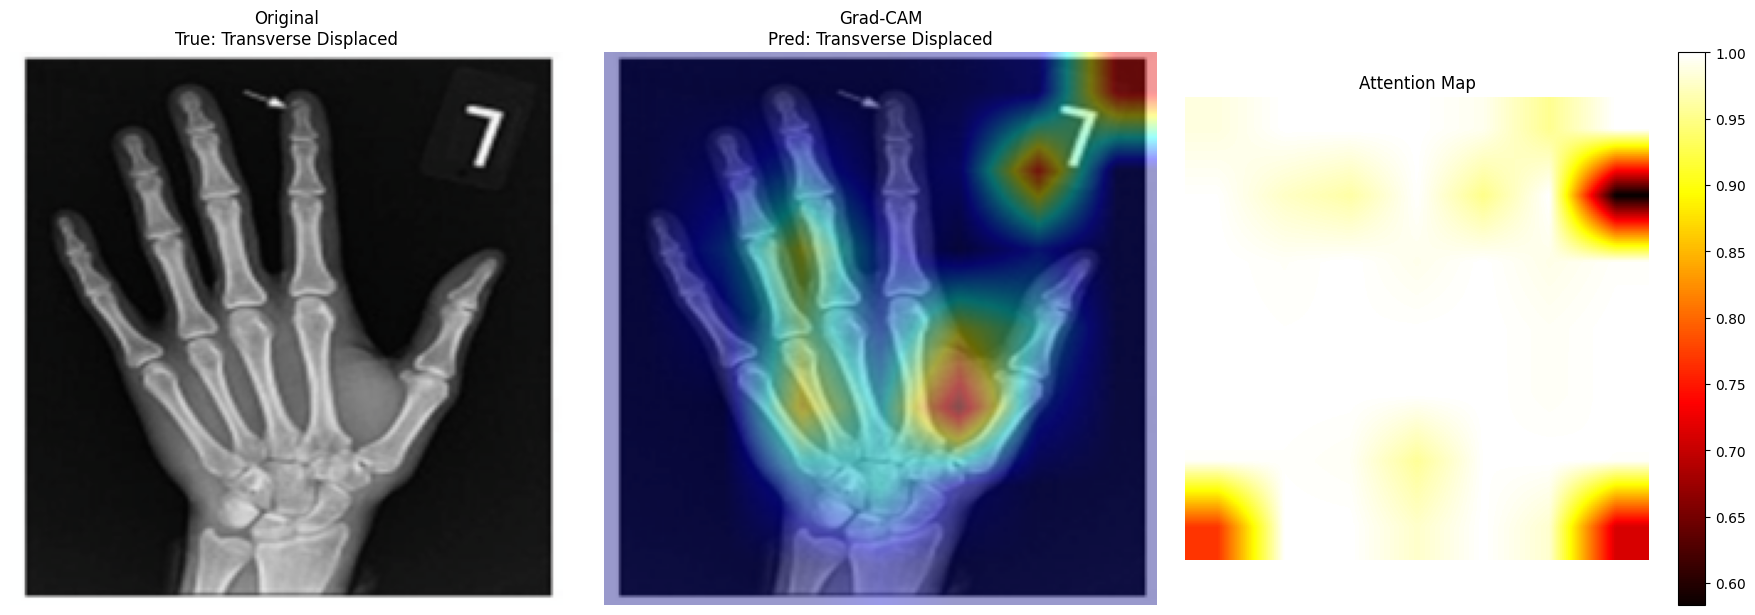

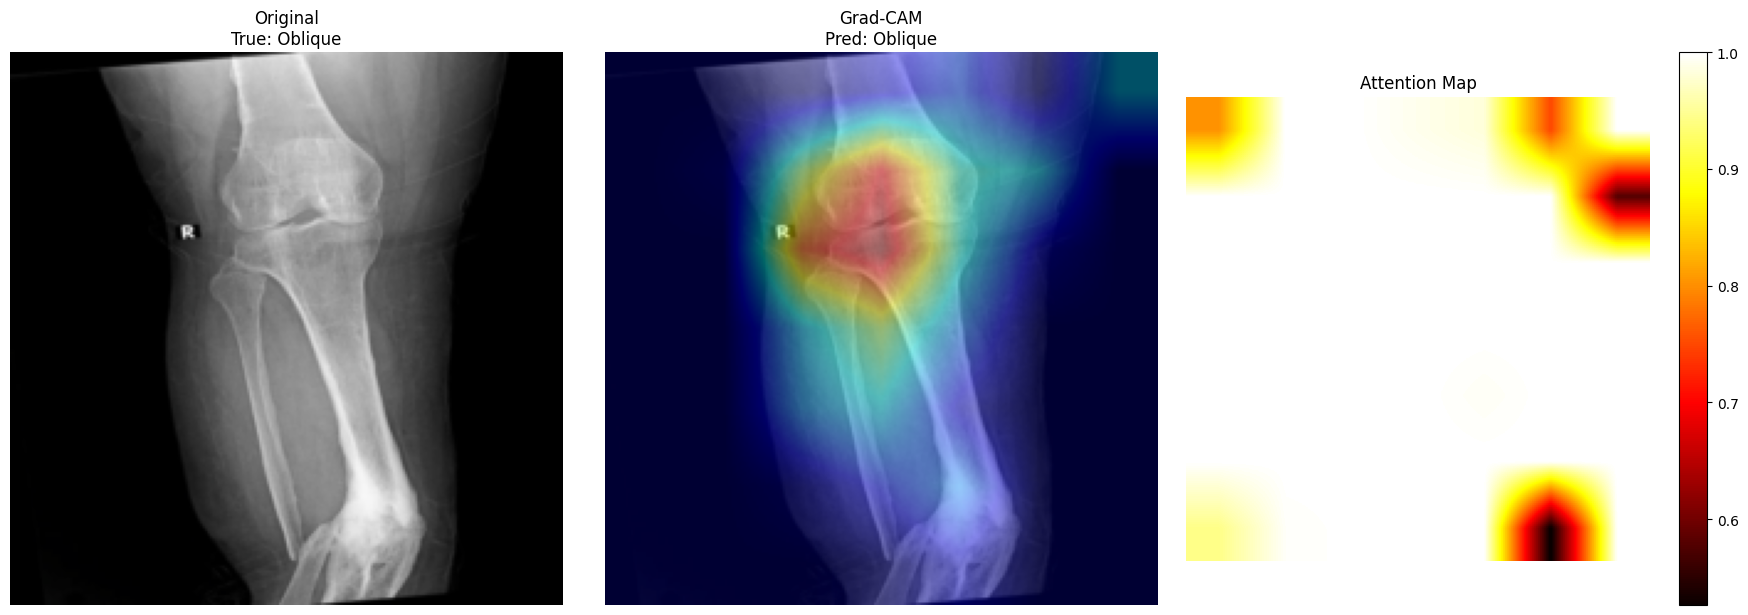

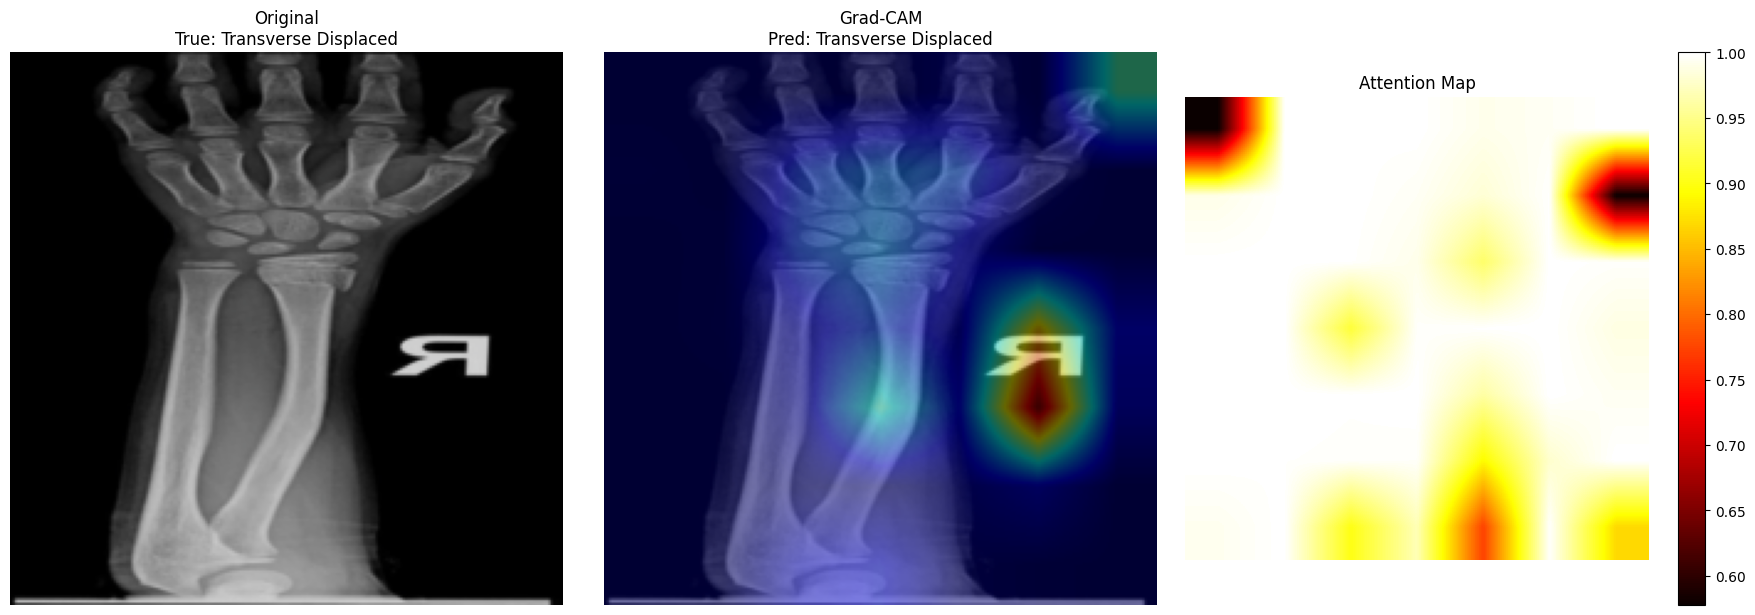

In [37]:
# Visualize random samples
print("\nVisualizing Random Samples with Grad-CAM...")
visualize_gradcam(model, test_loader, CLASS_NAMES)

import pandas as pd
import random


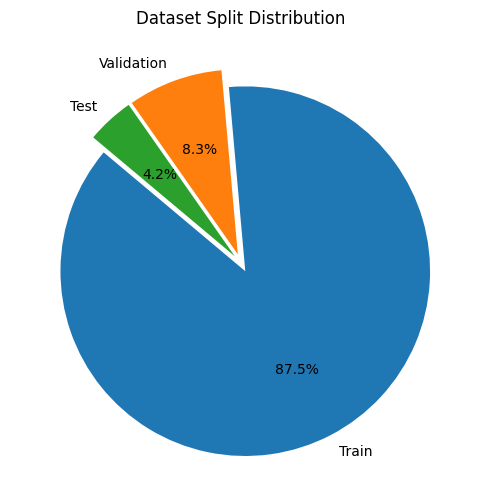

In [38]:
# -----------------------------
# 1. Dataset Split Pie Chart
# -----------------------------
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
labels = ["Train", "Validation", "Test"]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=(0.05, 0.05, 0.05))
plt.title("Dataset Split Distribution")
plt.show()

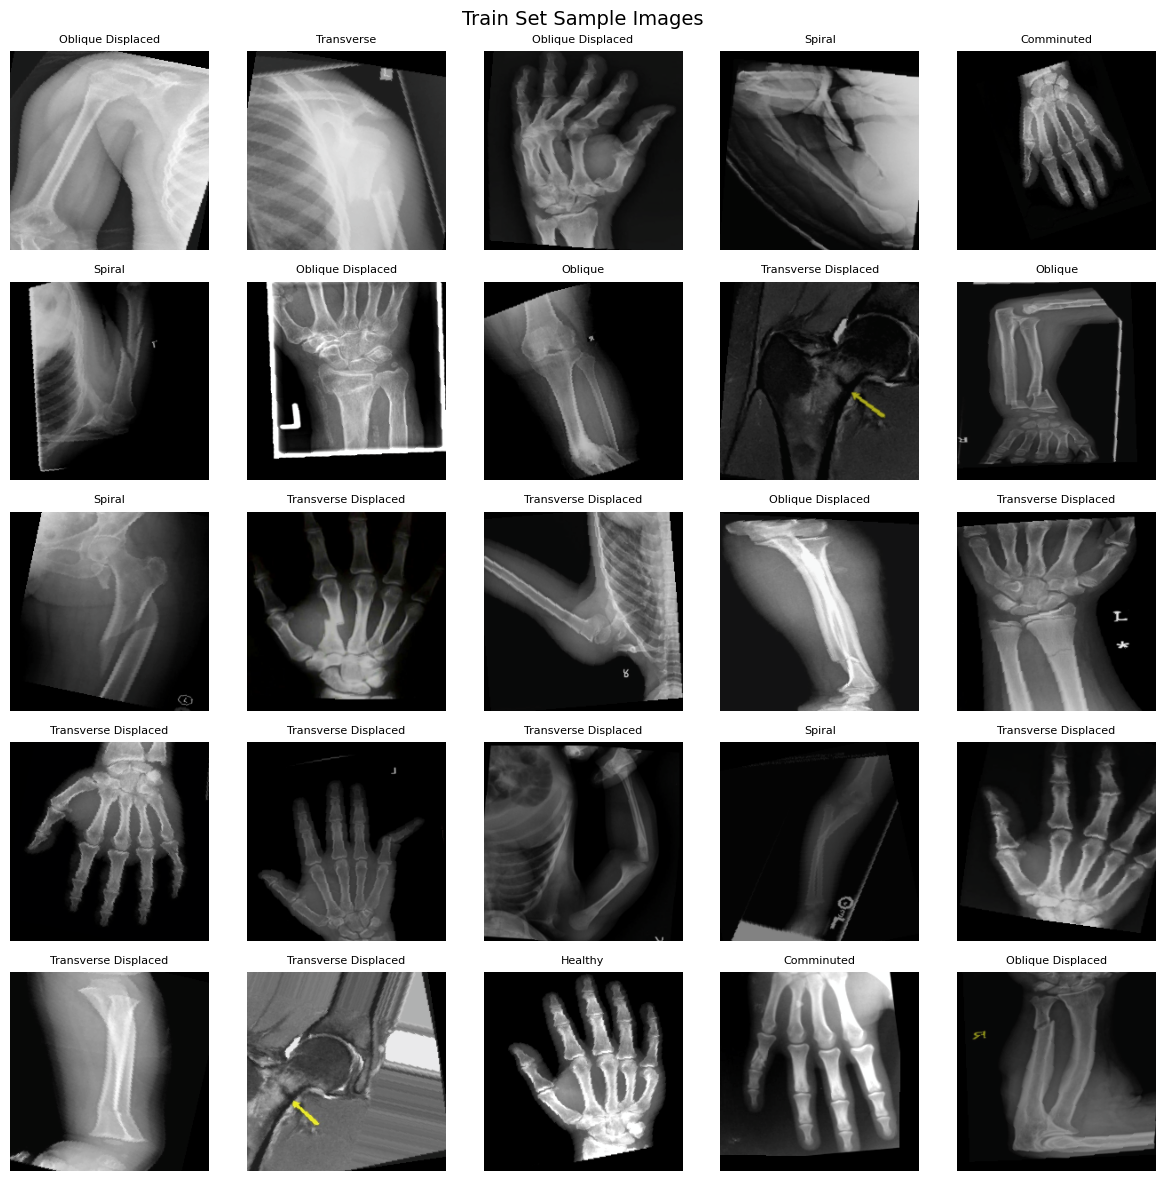

In [39]:
# -----------------------------
# 2. Show 5x5 Sample Images
# -----------------------------
def show_sample_images(dataset, title="Sample Images", n=25):
    indices = random.sample(range(len(dataset)), min(n, len(dataset)))
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(CLASS_NAMES[label], fontsize=8)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset, "Train Set Sample Images")

In [40]:
# -----------------------------
# 3. Dataset Info Table
# -----------------------------
dataset_info = {
    "Source Path": [
        "train/images",
        "valid/images",
        "test/images",
    ],
    "Total Images": [len(train_dataset), len(val_dataset), len(test_dataset)],
    "Classes": [len(CLASS_NAMES)]*3,
    "Image Type": ["X-ray + MRI"]*3,
}
df_info = pd.DataFrame(dataset_info)
print("\nDataset Summary Table:")
print(df_info)



Dataset Summary Table:
    Source Path  Total Images  Classes   Image Type
0  train/images          1347       10  X-ray + MRI
1  valid/images           128       10  X-ray + MRI
2   test/images            64       10  X-ray + MRI


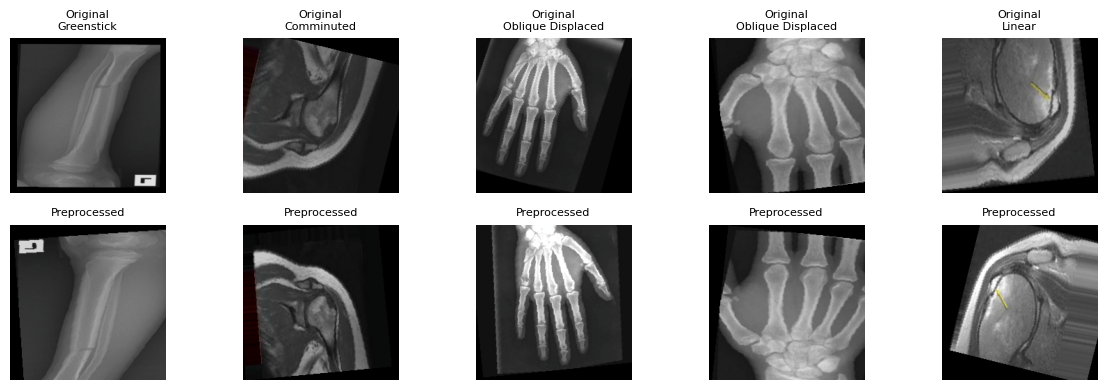

In [41]:
# -----------------------------
# 4. Preprocess Visualization
# -----------------------------
def visualize_preprocessing(dataset, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        plt.subplot(2, n, i + 1)
        plt.imshow(img)
        plt.title(f"Original\n{CLASS_NAMES[label]}", fontsize=8)
        plt.axis("off")
        
        # Augmented version
        img_aug, _ = train_dataset[i]
        img_aug = img_aug.permute(1, 2, 0).numpy()
        img_aug = img_aug * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_aug = np.clip(img_aug, 0, 1)
        
        plt.subplot(2, n, n + i + 1)
        plt.imshow(img_aug)
        plt.title("Preprocessed", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_preprocessing(train_dataset, n=5)


In [42]:
# -----------------------------
# 5. Model Summary
# -----------------------------
def print_model_summary(model):
    print(f"\n{'Layer':<40} {'Param #':<15}")
    print("="*60)
    total_params = 0
    trainable_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # leaf module
            params = sum(p.numel() for p in module.parameters())
            trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
            total_params += params
            trainable_params += trainable
            print(f"{name:<40} {params:<15}")
    print("="*60)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {total_params-trainable_params:,}")

print_model_summary(model)



Layer                                    Param #        
base_model.features.0.0                  1296           
base_model.features.0.1                  96             
base_model.features.0.2                  0              
base_model.features.1.0.block.0.0        432            
base_model.features.1.0.block.0.1        96             
base_model.features.1.0.block.0.2        0              
base_model.features.1.0.block.1.avgpool  0              
base_model.features.1.0.block.1.fc1      588            
base_model.features.1.0.block.1.fc2      624            
base_model.features.1.0.block.1.activation 0              
base_model.features.1.0.block.1.scale_activation 0              
base_model.features.1.0.block.2.0        1152           
base_model.features.1.0.block.2.1        48             
base_model.features.1.0.stochastic_depth 0              
base_model.features.1.1.block.0.0        216            
base_model.features.1.1.block.0.1        48             
base_model.features.

In [44]:
!pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [45]:
# -----------------------------
# 6. Model Architecture Visualization
# -----------------------------
try:
    from torchviz import make_dot
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    output, _ = model(sample_input)
    dot = make_dot(output, params=dict(model.named_parameters()))
    dot.format = "png"
    dot.render("model_architecture")
    from PIL import Image as PILImage
    plt.figure(figsize=(12, 12))
    plt.imshow(PILImage.open("model_architecture.png"))
    plt.axis("off")
    plt.title("Fracture Classifier Architecture")
    plt.show()
except Exception as e:
    print("Model architecture visualization skipped:", e)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.831988 to fit


Model architecture visualization skipped: Image size (769270859 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


<Figure size 1200x1200 with 0 Axes>

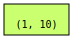

In [46]:


from torchviz import make_dot
from IPython.display import SVG, display
import torch

# Create a small dummy input, run forward to get an output tensor
sample_input = torch.randn(1, 3, 224, 224).to(device)
model.eval()
with torch.no_grad():
    # If your model returns (output, extra) adapt accordingly:
    out = model(sample_input)
    # if the model returns tuple like (out, aux), use out[0] or adjust:
    if isinstance(out, tuple):
        graph_tensor = out[0]
    else:
        graph_tensor = out

# Option: reduce parameter nodes by sending a smaller dict (top-level module params only)
# This keeps the graph lean — include only top-level named params, not every layer param.
top_params = {k: v for k, v in model.named_parameters() if '.' not in k}  

dot = make_dot(graph_tensor, params=top_params)   # smaller graph
dot.format = "svg"
dot.render("model_architecture")   # produces model_architecture.svg

# display SVG inline (scales nicely)
display(SVG(filename="model_architecture.svg"))


In [47]:
import zipfile
import os

zip_path = "/kaggle/working/fracture_outputs.zip"

files_to_zip = [
    "/kaggle/working/best_model.pth",
    "/kaggle/working/model_architecture.png",
    "/kaggle/working/model_architecture.svg",
    "/kaggle/working/model_architecture"   # graphviz source
]

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for fp in files_to_zip:
        if os.path.exists(fp):
            zf.write(fp, arcname=os.path.basename(fp))

print("Created ZIP:", zip_path)


Created ZIP: /kaggle/working/fracture_outputs.zip


In [52]:
from IPython.display import FileLink
FileLink("/kaggle/working/fracture_outputs.zip")


/kaggle/working/fracture_outputs.zip